# Mecánica de Medios Continuos
## Por Jorge I. Zuluaga
### Cuadernos de exploración numérica
### **CFD Smoothed Particle Hydrodynamics (SPH): Una estrella en colapso**

El siguiente código es basado en el modelo 1-D sencillo de una estrella desarrollado por Monahan & Price en 2020 ([artículo en MNRAS](https://articles.adsabs.harvard.edu/pdf/2004MNRAS.350.1449M)). El código se basa en el programa publicado en este [repositorio de GitHub](https://github.com/pmocz/sph-python). Los nombres de las rutinas y algunas variables se han modificado.

### Módulos y paquetes externos requeridos

In [37]:
!pip install -q celluloid matplotlib numpy tqdm

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from celluloid import Camera
from IPython.display import HTML

### Definición de las funciones básicas

Lo primero que tenemos que definir es el kernel y su gradiente:

In [39]:
def W( x, y, z, h):
	"""Kernel Gaussiano
	"""
	r = np.sqrt(x**2 + y**2 + z**2)
	w = (1.0/(h*np.sqrt(np.pi)))**3*np.exp(-r**2/h**2)
	return w

def gradW( x, y, z, h ):
	"""Gradiente del kernel gaussiano
	"""
	r = np.sqrt(x**2 + y**2 + z**2)
	n = -2*np.exp(-r**2/h**2)/h**5/(np.pi)**(3/2)
	wx = n*x
	wy = n*y
	wz = n*z
	return wx, wy, wz

En las fórmulas de SPH es necesario calcular el Kernel que típicamente depende de la distancia entre las partículas:

$$
<f\left(\boldsymbol{x}_i\right)>=\sum_{j=1}^N \frac{m_j}{\rho_j} f\left(\boldsymbol{x}_j\right) \cdot W_{i j}
$$
donde:

$$
W_{ij} = W\left(\boldsymbol{x}_i-\boldsymbol{x}_j, h\right)
$$

Necesitamos entonces una rutina para calcular la distancia entre todas las partículas, esta rutina lo hace, y lo mejor, lo hace de la forma más eficiente posible usando para ello herramientas disponibles en `numpy`:


In [40]:
def vectores_relativos(ri, rj):
	"""Obtiene los vectores relativos entre partículas

  Recibe:
    ri: Matriz M x 3 con la posición de las partículas
    rj: Matriz N x 3 con la posición de otras partículas

  Devuelve:
    dx, dy, dz: Matrices M x N con las separaciones entre las partículas
	"""
	M = ri.shape[0]
	N = rj.shape[0]

	# Obtiene las componentes x,y,z de las posiciones
	rix = ri[:,0].reshape((M,1))
	riy = ri[:,1].reshape((M,1))
	riz = ri[:,2].reshape((M,1))
	rjx = rj[:,0].reshape((N,1))
	rjy = rj[:,1].reshape((N,1))
	rjz = rj[:,2].reshape((N,1))

	# Vectores relativos
	dx = rix - rjx.T
	dy = riy - rjy.T
	dz = riz - rjz.T

	return dx, dy, dz

Los campos de densidad y presión serán:

In [41]:
def densidad(r, pos, m, h):
	"""Obtiene el valor del campo de densidad en la posición r

  Recibe:
    r: matriz M x 3 donde se quiere calcular el campo
    pos: matiz N x 3 donde están las partículas de SPH
    m: masa de las partículas de SPH
    h: longitud de suavizado o soporte del kernel

  Devuelve:
    rho: Vector M x 1 con las densidades
	"""
	M = r.shape[0]
	dx, dy, dz = vectores_relativos(r, pos);
	rho = np.sum(m*W(dx,dy,dz,h),1).reshape((M,1))

	return rho

def presion(rho, k, gamma):
	""" Ecuación de estado politrópica del medio

  Recibe:
    rho: valor o vector de densidades:
    k: constante de la ecuación de estado
    n: índice politrópico

  Devuelve:
    P: valor o vedtor de presiones
	"""
	P = k*rho**(1+1/gamma)
	return P

### Propiedades y condiciones iniciales

Vamos a definir el sistema inicial que corresponde a un número $N$ de partículas que tienen una masa total $M$ y con posiciones y velocidades aleatorias en un cubo de lado $2$ (coordenadas entre -1 y 1):

In [42]:
# Propiedades del medio
M = 2
N = 500
k = 0.1
gamma = 1 # Indice adiabatico
phi = 2 # Constante de la fuerza del medio
nu = 2 # Visosidad modelada

# Propiedades del SPH
m = M/N
h = 0.1

# Genera posiciones y velocidades
def reinicia_condiciones_iniciales(N):
  pos = np.random.randn(N,3)
  vel = np.zeros_like(pos)
  return pos, vel

pos, vel = reinicia_condiciones_iniciales(N)

Para mostrar un ejemplo de cómo se usan las rutinas que definimos antes, calculemos por ejemplo la densidad del fluído en dos puntos específicos del espacio:

In [43]:
densidad(np.array([[0.5,0.5,0.5],[0,0,0]]),pos,m,h)

array([[0.01654236],
       [0.00533669]])

También podemos calcular la densidad en el lugar en el que están todas las partículas:

In [44]:
rho = densidad(pos, pos, m, h)

Grafiquemos las posiciones, codificando con colores las desnsidades:

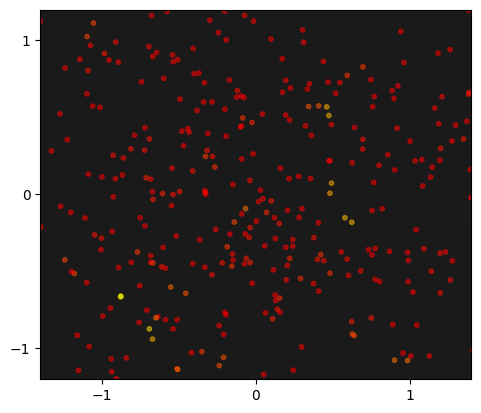

In [45]:
fig,ax = plt.subplots()
plt.scatter(pos[:,0],pos[:,1],c=rho,cmap='autumn', s=10, alpha=0.5)
ax.set(xlim=(-1.4, 1.4), ylim=(-1.2, 1.2))
ax.set_aspect('equal', 'box')
ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])
ax.set_facecolor('black')
ax.set_facecolor((.1,.1,.1))

Puede notarse que donde las partículas están más concentradas, la densidad también es más alta.

### Las ecuaciones de movimiento

Ahora viene la parte más complicada, escribir la aceleración que sufre cada partícula, es decir, la versión Lagrangiana de la ecuación de Navier-Stokes. Usaremos en este caso un modelo simple de viscosidad introducida simplemente con la prescripción $\vec F \propto -\nu\vec v$. Para las fuerzas entre las partículas asumiremos que se atraen (o repelen) como si hubiera resortes entre ellas. Este modelo es útil para simular cuerpos físicos autogravitantes como se demuestra en el artículo citado al principio:

In [46]:
def aceleracion(pos, vel, m, h, k, gamma, phi, nu):
  """Calcula la aceleración de cada partícula

  Recibe:
    pos: matriz N x 3 con las posiciones de las partículas
    vel: matriz N x 3 con las velocidades de las partículas
    m: masa de cada partícula
    h: longitud de suavizado
    k, gamma: parametros de la ecuación de estado
    phi: constante del potencial externo
    nu: constante de viscosidad

  Devuelve:
    a: matriz N x 3 con las aceleraciones de las partículas
  """
  N = pos.shape[0]

  # Calcula primero las desnsidades
  rho = densidad(pos, pos, m, h)

  # Calcula las presiones
  P = presion(rho, k, gamma)

  # Vectores relativos para el calculo del gradiente
  dx, dy, dz = vectores_relativos(pos, pos)
  dWx, dWy, dWz = gradW(dx, dy, dz, h)

  # Contribución del gradiente de presión
  ax = -np.sum(m*(P/rho**2+P.T/rho.T**2)*dWx,1).reshape((N,1))
  ay = -np.sum(m*(P/rho**2+P.T/rho.T**2)*dWy,1).reshape((N,1))
  az = -np.sum(m*(P/rho**2+P.T/rho.T**2)*dWz,1).reshape((N,1))

  # Juntamos las aceleraciones
  a = np.hstack((ax,ay,az))

  # Contribución de la viscosidad
  a -= nu*vel

  # Potencial externo: asumimos un potencial del tipo oscilador armónico
  a -= phi * pos

  return a

Podemos ahora calcular las aceleraciones:

In [47]:
a = aceleracion(pos, vel, m, h, k, gamma, phi, nu)

Para mover las partículas vamos a usar un esquema de integración simple del tipo Verlet:

In [48]:
dt = 0.05
pos, vel = reinicia_condiciones_iniciales(N)
vel += a*dt/2
pos += vel*dt
a = aceleracion(pos, vel, m, h, k, gamma, phi, nu)
vel += a*dt/2

Veamos las nuevas posiciones:


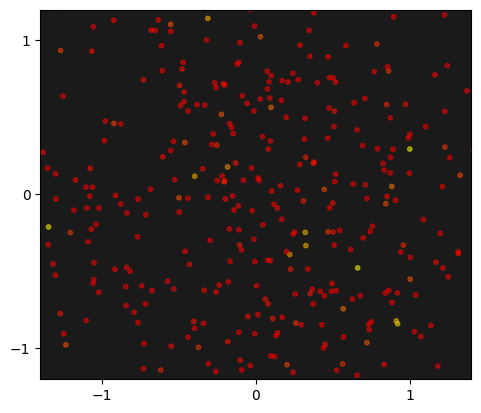

In [49]:
fig,ax = plt.subplots()
plt.scatter(pos[:,0],pos[:,1],c=rho,cmap='autumn', s=10, alpha=0.5)
ax.set(xlim=(-1.4, 1.4), ylim=(-1.2, 1.2))
ax.set_aspect('equal', 'box')
ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])
ax.set_facecolor('black')
ax.set_facecolor((.1,.1,.1))

Repitamos el procedimiento:

In [50]:
for i in tqdm(range(100)):
  vel += a*dt/2
  pos += vel*dt
  a = aceleracion(pos, vel, m, h, k, gamma, phi, nu)
  vel += a*dt/2

100%|██████████| 100/100 [00:02<00:00, 36.04it/s]


Y miremos donde quedaron las partículas:

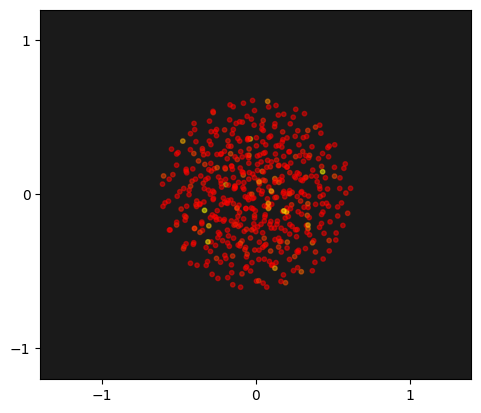

In [51]:
fig,ax = plt.subplots()
plt.scatter(pos[:,0],pos[:,1],c=rho,cmap='autumn', s=10, alpha=0.5)
ax.set(xlim=(-1.4, 1.4), ylim=(-1.2, 1.2))
ax.set_aspect('equal', 'box')
ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])
ax.set_facecolor('black')
ax.set_facecolor((.1,.1,.1))

Como vemos las partíuculas tendieron a agruparse por efecto de su mutua atracción, pero no colapsaron en un punto. Animemos ahora el proceso:

### Una animación del colapso

Vamos ahora a animar el proceso:

100%|██████████| 100/100 [00:06<00:00, 14.95it/s]


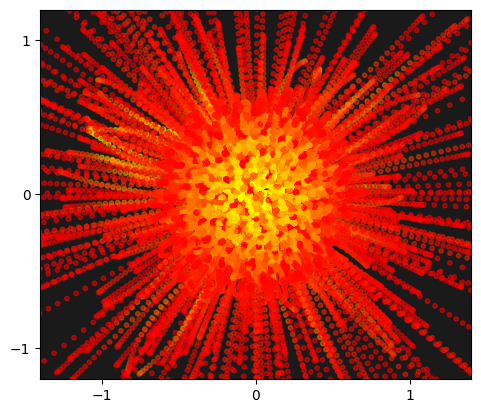

In [52]:
pos, vel = reinicia_condiciones_iniciales(N)

fig,ax = plt.subplots()
ax.set(xlim=(-1.4, 1.4), ylim=(-1.2, 1.2))
ax.set_aspect('equal', 'box')
ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])
ax.set_facecolor('black')
ax.set_facecolor((.1,.1,.1))
camera = Camera(fig)

for i in tqdm(range(100)):
  a = aceleracion(pos, vel, m, h, k, gamma, phi, nu)
  vel += a*dt/2
  pos += vel*dt
  a = aceleracion(pos, vel, m, h, k, gamma, phi, nu)
  vel += a*dt/2

  rho = densidad(pos, pos, m, h)
  plt.scatter(pos[:,0],pos[:,1],c=rho,cmap='autumn', s=10, alpha=0.5)
  camera.snap()

Hagamos la animación:

In [53]:
anim = camera.animate()

In [54]:
HTML(anim.to_html5_video())

El código se puede ejecutar en la terminal de Linux y los efectos que se pueden ver son muy interesantes. ¡Intentenlo!

In [55]:
%%file sph.py

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def W( x, y, z, h):
	"""Kernel Gaussiano
	"""
	r = np.sqrt(x**2 + y**2 + z**2)
	w = (1.0/(h*np.sqrt(np.pi)))**3*np.exp(-r**2/h**2)
	return w

def gradW( x, y, z, h ):
	"""Gradiente del kernel gaussiano
	"""
	r = np.sqrt(x**2 + y**2 + z**2)
	n = -2*np.exp(-r**2/h**2)/h**5/(np.pi)**(3/2)
	wx = n*x
	wy = n*y
	wz = n*z
	return wx, wy, wz

def vectores_relativos(ri, rj):
	"""Obtiene los vectores relativos entre partículas

  Recibe:
    ri: Matriz M x 3 con la posición de las partículas
    rj: Matriz N x 3 con la posición de otras partículas

  Devuelve:
    dx, dy, dz: Matrices M x N con las separaciones entre las partículas
	"""
	M = ri.shape[0]
	N = rj.shape[0]

	# Obtiene las componentes x,y,z de las posiciones
	rix = ri[:,0].reshape((M,1))
	riy = ri[:,1].reshape((M,1))
	riz = ri[:,2].reshape((M,1))
	rjx = rj[:,0].reshape((N,1))
	rjy = rj[:,1].reshape((N,1))
	rjz = rj[:,2].reshape((N,1))

	# Vectores relativos
	dx = rix - rjx.T
	dy = riy - rjy.T
	dz = riz - rjz.T

	return dx, dy, dz

def densidad(r, pos, m, h):
	"""Obtiene el valor del campo de densidad en la posición r

  Recibe:
    r: matriz M x 3 donde se quiere calcular el campo
    pos: matiz N x 3 donde están las partículas de SPH
    m: masa de las partículas de SPH
    h: longitud de suavizado o soporte del kernel

  Devuelve:
    rho: Vector M x 1 con las densidades
	"""
	M = r.shape[0]
	dx, dy, dz = vectores_relativos(r, pos);
	rho = np.sum(m*W(dx,dy,dz,h),1).reshape((M,1))

	return rho

def presion(rho, k, gamma):
	""" Ecuación de estado politrópica del medio

  Recibe:
    rho: valor o vector de densidades:
    k: constante de la ecuación de estado
    n: índice politrópico

  Devuelve:
    P: valor o vedtor de presiones
	"""
	P = k*rho**(1+1/gamma)
	return P

def aceleracion(pos, vel, m, h, k, gamma, phi, nu):
  """Calcula la aceleración de cada partícula

  Recibe:
    pos: matriz N x 3 con las posiciones de las partículas
    vel: matriz N x 3 con las velocidades de las partículas
    m: masa de cada partícula
    h: longitud de suavizado
    k, gamma: parametros de la ecuación de estado
    phi: constante del potencial externo
    nu: constante de viscosidad

  Devuelve:
    a: matriz N x 3 con las aceleraciones de las partículas
  """
  N = pos.shape[0]

  # Calcula primero las desnsidades
  rho = densidad(pos, pos, m, h)

  # Calcula las presiones
  P = presion(rho, k, gamma)

  # Vectores relativos para el calculo del gradiente
  dx, dy, dz = vectores_relativos(pos, pos)
  dWx, dWy, dWz = gradW(dx, dy, dz, h)

  # Contribución del gradiente de presión
  ax = -np.sum(m*(P/rho**2+P.T/rho.T**2)*dWx,1).reshape((N,1))
  ay = -np.sum(m*(P/rho**2+P.T/rho.T**2)*dWy,1).reshape((N,1))
  az = -np.sum(m*(P/rho**2+P.T/rho.T**2)*dWz,1).reshape((N,1))

  # Juntamos las aceleraciones
  a = np.hstack((ax,ay,az))

  # Contribución de la viscosidad
  a -= nu*vel

  # Potencial externo: asumimos un potencial del tipo oscilador armónico
  a -= phi * pos

  return a

# Genera posiciones y velocidades
def reinicia_condiciones_iniciales(N):
  pos = np.random.randn(N,3)
  vel = np.zeros_like(pos)
  return pos, vel

# Propiedades del medio
M = 2
N = 500
k = 0.1
gamma = 1 # Indice adiabatico
phi = 2 # Constante de la fuerza del medio
nu = 1 # Visosidad modelada

# Propiedades del SPH
m = M/N
h = 0.1

pos, vel = reinicia_condiciones_iniciales(N)

pos, vel = reinicia_condiciones_iniciales(N)

fig,ax = plt.subplots()


dt = 0.05
for i in tqdm(range(100)):
  plt.cla()
  a = aceleracion(pos, vel, m, h, k, gamma, phi, nu)
  vel += a*dt/2
  pos += vel*dt
  a = aceleracion(pos, vel, m, h, k, gamma, phi, nu)
  vel += a*dt/2

  rho = densidad(pos, pos, m, h)
  plt.scatter(pos[:,0],pos[:,1],c=rho,cmap='autumn', s=10, alpha=0.5)
  ax.set(xlim=(-1.4, 1.4), ylim=(-1.2, 1.2))
  ax.set_aspect('equal', 'box')
  ax.set_xticks([-1,0,1])
  ax.set_yticks([-1,0,1])
  ax.set_facecolor('black')
  ax.set_facecolor((.1,.1,.1))
  plt.pause(0.001)

plt.show()

Overwriting sph.py


----

## Solución Mini Tarea

Bryan Camilo Restrepo Arcila

Primero se hace la simulación  hasta alcanzar el equilibrio hidrostático, osea que la velocidad  promedio de todas las particulas debe de ser inferior a un cvalor dado

Importando las librerias necesarias

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Definiendo las funciones para la simulación

In [117]:
def W( x, y, z, h):
	"""Kernel Gaussiano
	"""
	r = np.sqrt(x**2 + y**2 + z**2)
	w = (1.0/(h*np.sqrt(np.pi)))**3*np.exp(-r**2/h**2)
	return w

def gradW( x, y, z, h ):
	"""Gradiente del kernel gaussiano
	"""
	r = np.sqrt(x**2 + y**2 + z**2)
	n = -2*np.exp(-r**2/h**2)/h**5/(np.pi)**(3/2)
	wx = n*x
	wy = n*y
	wz = n*z
	return wx, wy, wz

def vectores_relativos(ri, rj):
	"""Obtiene los vectores relativos entre partículas

  Recibe:
    ri: Matriz M x 3 con la posición de las partículas
    rj: Matriz N x 3 con la posición de otras partículas

  Devuelve:
    dx, dy, dz: Matrices M x N con las separaciones entre las partículas
	"""
	M = ri.shape[0]
	N = rj.shape[0]

	# Obtiene las componentes x,y,z de las posiciones
	rix = ri[:,0].reshape((M,1))
	riy = ri[:,1].reshape((M,1))
	riz = ri[:,2].reshape((M,1))
	rjx = rj[:,0].reshape((N,1))
	rjy = rj[:,1].reshape((N,1))
	rjz = rj[:,2].reshape((N,1))

	# Vectores relativos
	dx = rix - rjx.T
	dy = riy - rjy.T
	dz = riz - rjz.T

	return dx, dy, dz

def densidad(r, pos, m, h):
	"""Obtiene el valor del campo de densidad en la posición r

  Recibe:
    r: matriz M x 3 donde se quiere calcular el campo
    pos: matiz N x 3 donde están las partículas de SPH
    m: masa de las partículas de SPH
    h: longitud de suavizado o soporte del kernel

  Devuelve:
    rho: Vector M x 1 con las densidades
	"""
	M = r.shape[0]
	dx, dy, dz = vectores_relativos(r, pos);
	rho = np.sum(m*W(dx,dy,dz,h),1).reshape((M,1))

	return rho

def presion(rho, k, gamma):
	""" Ecuación de estado politrópica del medio

  Recibe:
    rho: valor o vector de densidades:
    k: constante de la ecuación de estado
    n: índice politrópico

  Devuelve:
    P: valor o vedtor de presiones
	"""
	P = k*rho**(1+1/gamma)
	return P

def aceleracion(pos, vel, m, h, k, gamma, phi, nu):
  """Calcula la aceleración de cada partícula

  Recibe:
    pos: matriz N x 3 con las posiciones de las partículas
    vel: matriz N x 3 con las velocidades de las partículas
    m: masa de cada partícula
    h: longitud de suavizado
    k, gamma: parametros de la ecuación de estado
    phi: constante del potencial externo
    nu: constante de viscosidad

  Devuelve:
    a: matriz N x 3 con las aceleraciones de las partículas
  """
  N = pos.shape[0]

  # Calcula primero las desnsidades
  rho = densidad(pos, pos, m, h)

  # Calcula las presiones
  P = presion(rho, k, gamma)

  # Vectores relativos para el calculo del gradiente
  dx, dy, dz = vectores_relativos(pos, pos)
  dWx, dWy, dWz = gradW(dx, dy, dz, h)

  # Contribución del gradiente de presión
  ax = -np.sum(m*(P/rho**2+P.T/rho.T**2)*dWx,1).reshape((N,1))
  ay = -np.sum(m*(P/rho**2+P.T/rho.T**2)*dWy,1).reshape((N,1))
  az = -np.sum(m*(P/rho**2+P.T/rho.T**2)*dWz,1).reshape((N,1))

  # Juntamos las aceleraciones
  a = np.hstack((ax,ay,az))

  # Contribución de la viscosidad
  a -= nu*vel

  # Potencial externo: asumimos un potencial del tipo oscilador armónico
  a -= phi * pos

  return a

# Genera posiciones y velocidades
def reinicia_condiciones_iniciales(N):
  pos = np.random.randn(N,3)
  vel = np.zeros_like(pos)
  return pos, vel

Realizando la simulación

In [118]:
## Propiedades del medio
M = 2 # Masa de las partículas
N = 500 # Número de partículas
k = 0.1
gamma = 1 # Indice adiabatico
phi = 2 # Constante de la fuerza del medio
nu = 1 # Visosidad modelada

# Propiedades del SPH
m = M/N # Masa de cada partícula
h = 0.1 # Longitud de suavizado

# Reinicia el sistrema a sus condiciones iniciales
pos, vel = reinicia_condiciones_iniciales(N)

# Limite para la rapidez de las particulas
vlim = 0.05

# Paso de tiempo para la simulación
dt = 0.05

# Bucle principal de la simulación
while True:
  # Calucla los parámetros de la simulación
  a = aceleracion(pos, vel, m, h, k, gamma, phi, nu)
  vel += a*dt/2
  pos += vel*dt
  a = aceleracion(pos, vel, m, h, k, gamma, phi, nu)
  vel += a*dt/2

  # Encontramos la velocidad promedio de las particulas
  v_mean = np.mean(np.array([np.linalg.norm(v) for v in vel]))
  
  # Vericamos si la velocidad media es menor o igual a nuestra velocidad límite
  if v_mean <= vlim:
    break # Hemos encontrado el equilibrio hidrostático

Ahora que ya el sistema esta en equilibrio Hidrostático, veamos su perfil de densidad, teniendo en cuenta el promedio de este perfil en varias direcciones

In [119]:
# Function to generate random vectors wiht the same magnitude
def generate_random_vectors(num_vectors, dimension, magnitude):
    """
    Generate a list of random vectors with a given magnitude and arbitrary directions.
    
    Args:
    num_vectors (int): Number of vectors to generate.
    dimension (int): Dimension of each vector.
    magnitude (float): Desired magnitude of each vector.
    
    Returns:
    np.ndarray: Array of shape (num_vectors, dimension) with random vectors.
    """
    # Generate random vectors
    vectors = np.random.randn(num_vectors, dimension)
    
    # Normalize the vectors to have magnitude 1
    norms = np.linalg.norm(vectors, axis=1).reshape(num_vectors, 1)
    normalized_vectors = vectors / norms
    
    # Scale the vectors to have the desired magnitude
    scaled_vectors = normalized_vectors * magnitude
    
    return scaled_vectors

Generemos una lista de vectores con direcciones aleatorias pero igual magnitud

In [120]:
random_vectors = generate_random_vectors(15, 3, 0.001)

Ahora ya tenemos las direcciones en las cuales calcular  los perfiles de densidad y presión

In [121]:
# Encontremos la densidad en el origen
r = np.array([[0,0,0]])

# Inicializemos el array de densidades con la densidad del centro
rho = [densidad(r, pos, m, h)[0][0]]

# Incializamos el array de radios con el radio del centro
radii = [0]

# Bucle principal para la densidad
while True:
    # Veamos la densidad para cada uno de las direcciones dadas
    rho_s = densidad(random_vectors, pos, m, h)
    
    # Encontramos la densidad promedio
    rho_mean = np.mean(rho_s)
    
    # Añadir la densidad promedio al array de densidades
    rho.append(rho_mean)

    # Añadir el radio al array de radios
    radii.append(np.linalg.norm(random_vectors[0]))

    # La desnidad en la superficie es cero (o casi cero) esta es nuestra condicion de parada
    if rho_mean <= 0.001:
        break # Hemos encontrado la superficie

    # Ajustamos la magnitud de los vectores
    random_vectors *= 1.2

# Teniendo el array de densidades podemos encontrar a su vez el array de presiones
presiones = presion(np.array(rho), k, gamma)

Ahora ya tenemos la densidad promedio para diferentes radios hasta llegar a la superficie, veamos los resultados de manera gráfica

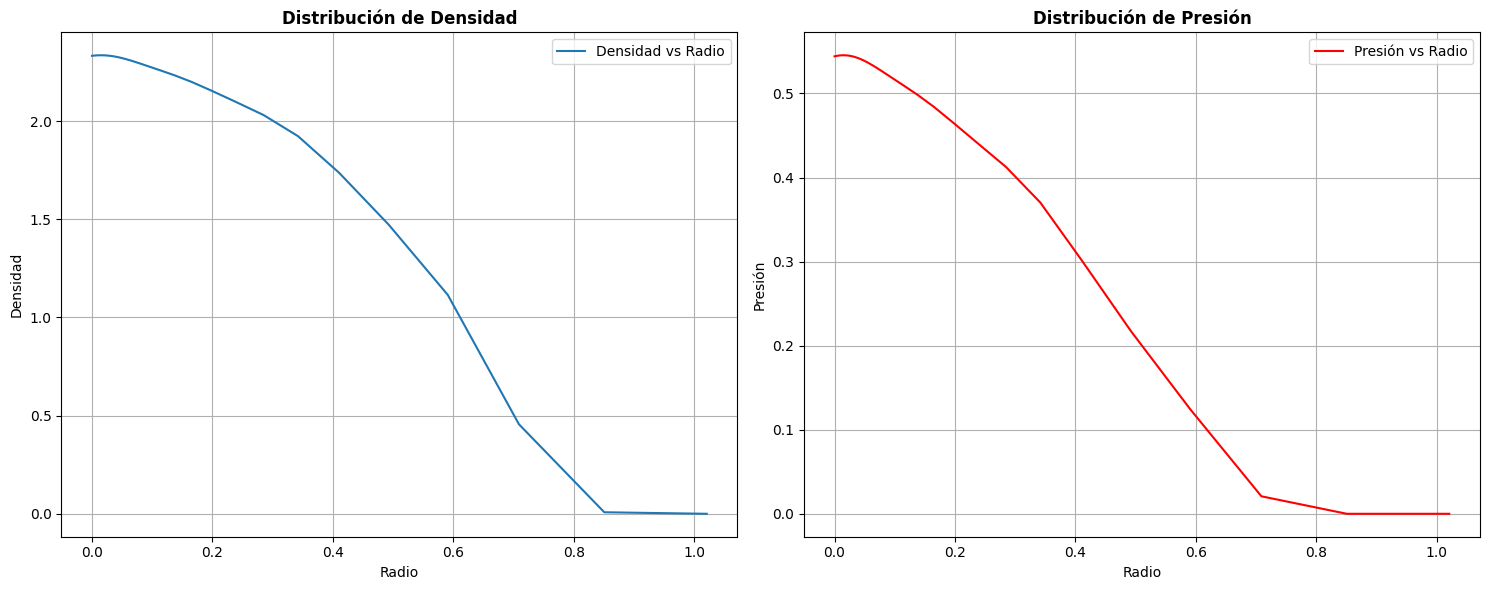

In [122]:
# Crear la figura y los ejes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graficar la densidad en el primer subplot
ax1.plot(radii, rho, label='Densidad vs Radio')
ax1.set_title('Distribución de Densidad', fontweight='bold')
ax1.set_xlabel('Radio')
ax1.set_ylabel('Densidad')

# Extender el eje x al doble de su longitud original sin duplicar puntos
original_xlim = ax1.get_xlim()
ax1.set_xlim([original_xlim[0], original_xlim[1] ])

# Agregar una rejilla
ax1.grid(True)

# Agregar una leyenda
ax1.legend()

# Graficar la presión en el segundo subplot
ax2.plot(radii, presiones, label='Presión vs Radio', color='r')
ax2.set_title('Distribución de Presión', fontweight='bold')
ax2.set_xlabel('Radio')
ax2.set_ylabel('Presión')

# Agregar una rejilla
ax2.grid(True)

# Agregar una leyenda
ax2.legend()

# Ajustar el layout para que no se solapen los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Ahora hagamos el mismo analisis pero para diferentes masas

In [123]:
## Propiedades del medio
M = [1, 2, 3, 5] # Array de masas
N = 500 # Número de partículas
k = 0.1
gamma = 1 # Indice adiabatico
phi = 2 # Constante de la fuerza del medio
nu = 1 # Visosidad modelada

# Propiedades del SPH
h = 0.1 # Longitud de suavizado

# Reinicia el sistrema a sus condiciones iniciales
pos, vel = reinicia_condiciones_iniciales(N)

# Limite para la rapidez de las particulas
vlim = 0.05

# Paso de tiempo para la simulación
dt = 0.05

Veamso la simulación  para las diferentes masas

In [124]:
# Definamos los arrays para guardar los resultados
time_ms = []
rho_ms = []
presiones_ms = []
radios_ms = []

for masa in M:
    # Masa de cada partícula
    m = masa/N

    # Reinicia el sistrema a sus condiciones iniciales
    pos, vel = reinicia_condiciones_iniciales(N)
    
    # Tiempo de la simulación
    time = 0

    # Bucle principal de la simulación
    while True:
        # Calucla los parámetros de la simulación
        a = aceleracion(pos, vel, masa/N, h, k, gamma, phi, nu)
        vel += a*dt/2
        pos += vel*dt
        a = aceleracion(pos, vel, masa/N, h, k, gamma, phi, nu)
        vel += a*dt/2
    
        # Encontramos la velocidad promedio de las particulas
        v_mean = np.mean(np.array([np.linalg.norm(v) for v in vel]))

        # Actualizamos el tiempo de la simulación
        time += dt
        
        # Vericamos si la velocidad media es menor o igual a nuestra velocidad límite
        if v_mean <= vlim:
            time_ms.append(time)
            break # Hemos encontrado el equilibrio hidrostático
    
    # Generate random vectors wiht the same magnitude
    random_vectors = generate_random_vectors(15, 3, 0.001)

    # Encontremos la densidad en el origen
    r = np.array([[0,0,0]])

    # Inicializemos el array de densidades con la densidad del centro
    rho = [densidad(r, pos, m, h)[0][0]]

    # Incializamos el array de radios con el radio del centro
    radii = [0]

    # Bucle principal para la densidad
    while True:
        # Veamos la densidad para cada uno de las direcciones dadas
        rho_s = densidad(random_vectors, pos, m, h)
        
        # Encontramos la densidad promedio
        rho_mean = np.mean(rho_s)
        
        # Añadir la densidad promedio al array de densidades
        rho.append(rho_mean)

        # Añadir el radio al array de radios
        radii.append(np.linalg.norm(random_vectors[0]))

        # La desnidad en la superficie es cero (o casi cero) esta es nuestra condicion de parada
        if rho_mean <= 0.001:
            break # Hemos encontrado la superficie

        # Ajustamos la magnitud de los vectores
        random_vectors *= 1.2

    # Teniendo el array de densidades podemos encontrar a su vez el array de presiones
    presiones = presion(np.array(rho), k, gamma)

    # Guardamos los resultados
    rho_ms.append(rho) # Densidades
    presiones_ms.append(presiones) # Presiones
    radios_ms.append(radii) # Radios

Gráficando los resultados

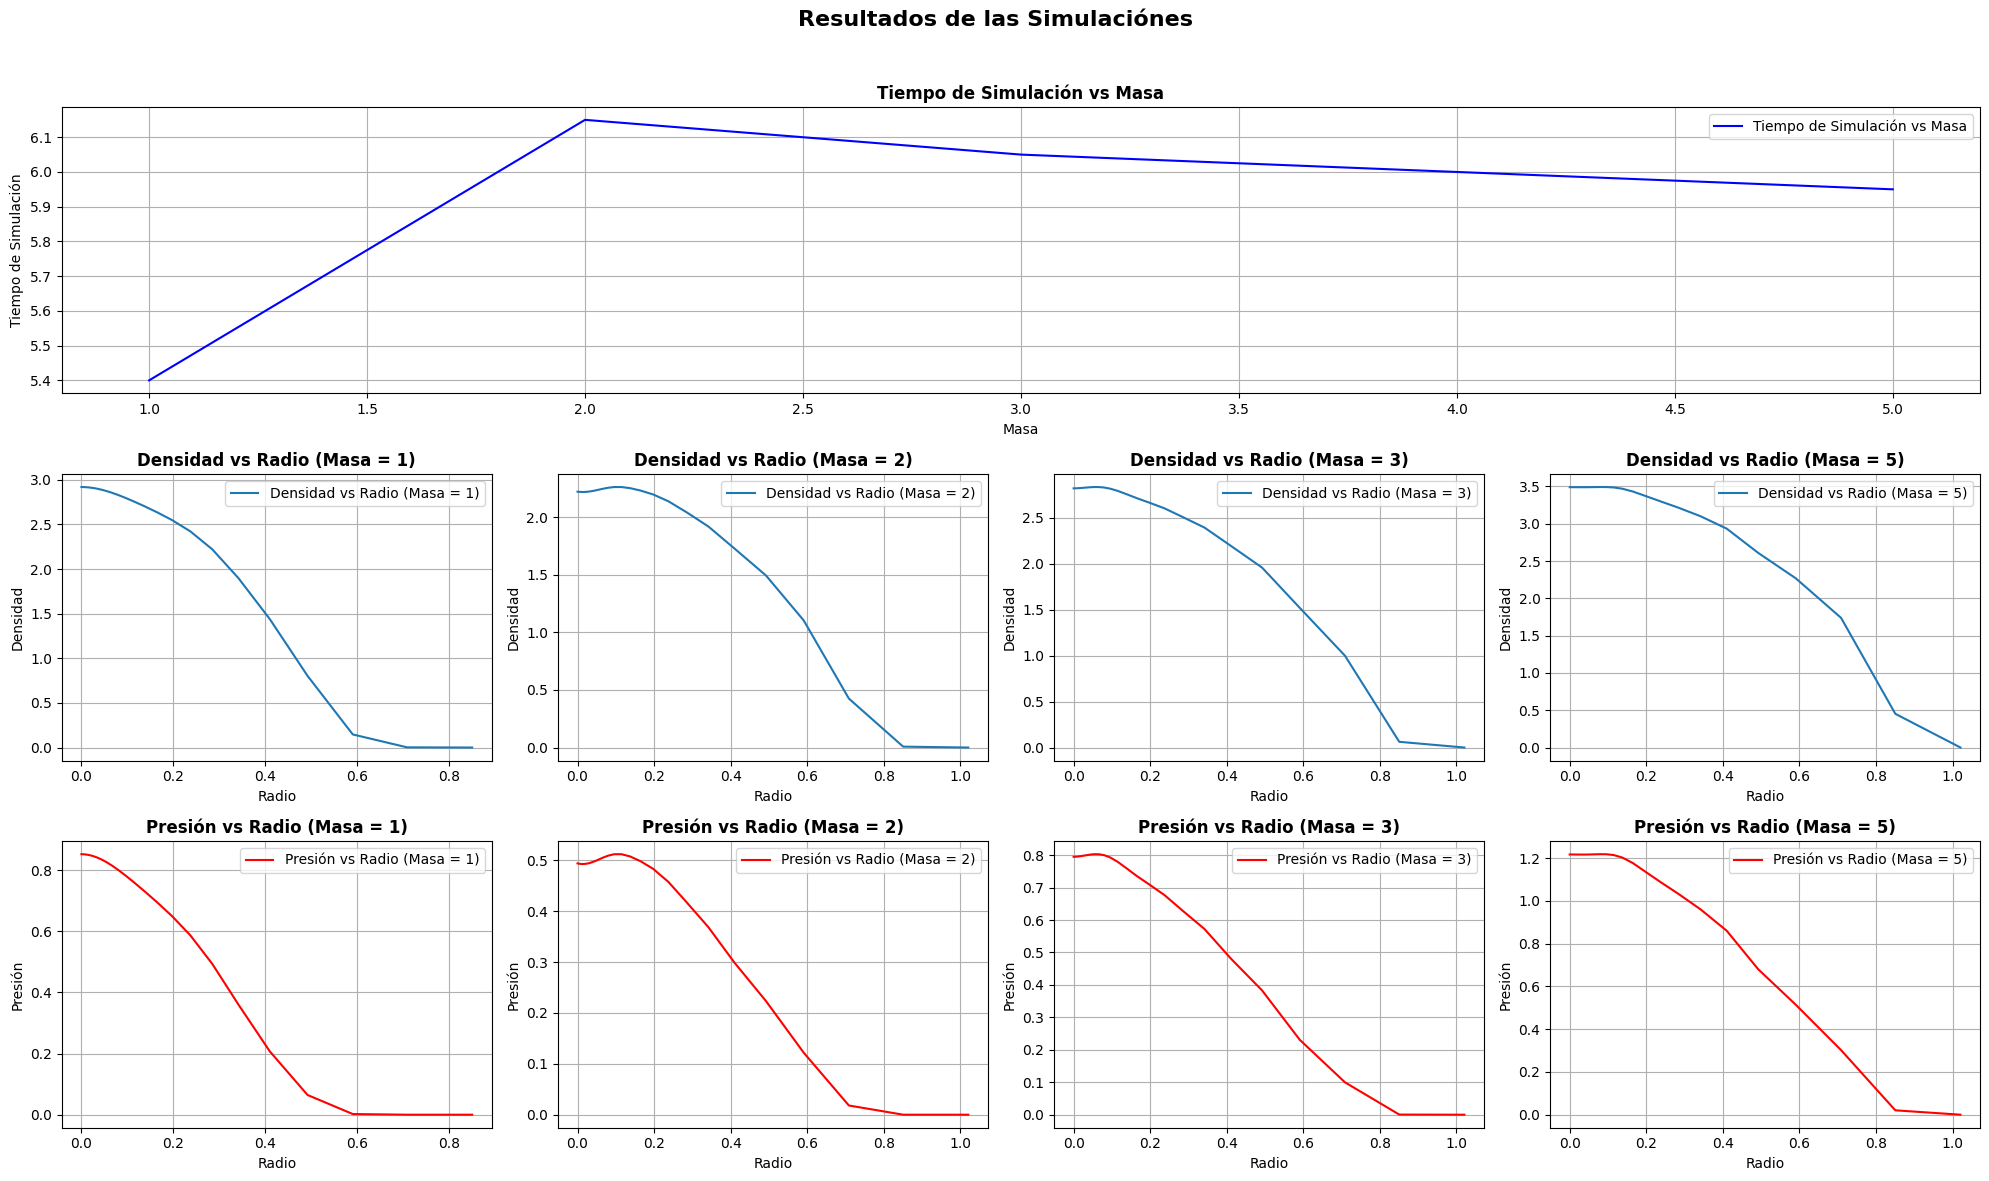

In [125]:
# Crear la figura y el gridspec
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(3, len(M))

# Graficar el tiempo de simulación vs masa en la primera fila
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(M, time_ms, label='Tiempo de Simulación vs Masa', color='b')
ax1.set_title('Tiempo de Simulación vs Masa', fontweight='bold')
ax1.set_xlabel('Masa')
ax1.set_ylabel('Tiempo de Simulación')
ax1.grid(True)
ax1.legend()

# Graficar densidad vs radio 
for i in range(len(M)):
    ax = fig.add_subplot(gs[1, i])
    ax.plot(radios_ms[i], rho_ms[i], label=f'Densidad vs Radio (Masa = {M[i]})')
    ax.set_title(f'Densidad vs Radio (Masa = {M[i]})', fontweight='bold')
    ax.set_xlabel('Radio')
    ax.set_ylabel('Densidad')
    ax.grid(True)
    ax.legend()

# Graficar presión vs radio 
for i in range(len(M)):
    ax = fig.add_subplot(gs[2, i])
    ax.plot(radios_ms[i], presiones_ms[i], label=f'Presión vs Radio (Masa = {M[i]})', color='r')
    ax.set_title(f'Presión vs Radio (Masa = {M[i]})', fontweight='bold')
    ax.set_xlabel('Radio')
    ax.set_ylabel('Presión')
    ax.grid(True)
    ax.legend()

# Agregar un título global
fig.suptitle('Resultados de las Simulaciónes', fontsize=16, fontweight='bold')

# Ajustar el layout para que no se solapen los subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar para dejar espacio para el título global

# Mostrar el gráfico
plt.show()

Algunas cosas apreciables directamente en el gŕafico
- Parece ser según los puntos estudiados que el tiempo de simulación  antes de alcanzar el equilibrio no depende de la masa
- El radio antes de alcanzar la superfice de las particulas en cuestión crece con la masa
- Para una masa de  3 la presion y la densidad máximas no estan en el centro (como se esperaría)

---

### Referencias

Para el desarrollo de algunas partes de este notebook, se utilizó ChatGPT, un modelo de lenguaje de OpenAI, como herramienta de asistencia. Las interacciones con ChatGPT ayudaron en la conceptualización, codificación y depuración de las secciones relevantes.